# Project Assignment 3: Amazon Review Classification System (Custom Implementation)

**Name/Group ID:** Berke Yusuf Uğurlu - Yusuf İpek (Group 6)

**Date:** April 21, 2025

**Course:** BBM 409 - Machine Learning Laboratory

---

**Objective:** Implement a Naive Bayes classifier from scratch using a custom Bag-of-Words (BoW) implementation to classify Amazon reviews as positive or negative. Library usage is restricted to data handling (pandas, numpy), visualization (matplotlib, seaborn), basic text processing (re), math operations (math, collections), and data splitting (train_test_split).

## 1. Import Libraries

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import re
import math
from collections import Counter, defaultdict

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data splitting (Allowed exception)
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(42)

## 2. Load and Explore the Dataset

In [2]:
# Load the Amazon reviews dataset
try:
    reviews_df = pd.read_csv('amazon_reviews.csv')
except FileNotFoundError:
    print("Error: 'amazon_reviews.csv' not found. Make sure the file is in the correct directory.")
    # Exit or handle error appropriately
    exit()

# Display the first few rows
print("Sample of the dataset:")
reviews_df.head()

Sample of the dataset:


,Title,Content,Star
0,Didn't work,No change in nails at all.,1.0
1,Worst nail product I have ever used.,Garbage! Do not waste your $$$. My nails were ...,1.0
2,Just didn't work,Nails are still brittle,1.0
3,Scum,Didn’t do any improvement at all.,1.0
4,Okay for cuticles,"Helped cuticles, didn't do much for my nails. ...",1.0


In [3]:
# Basic information about the dataset
print("Dataset shape:", reviews_df.shape)
print("\nColumn names:", reviews_df.columns.tolist())
print("\nData types:")
reviews_df.info()
print("\nMissing values:")
# Fill NaN in 'Content' and 'Title' before checking nulls for other columns if needed
reviews_df['Content'] = reviews_df['Content'].fillna("")
reviews_df['Title'] = reviews_df['Title'].fillna("")
print(reviews_df.isnull().sum())

Dataset shape: (72500, 3)

Column names: ['Title', 'Content', 'Star']

Data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72500 entries, 0 to 72499
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Title    72480 non-null  object 
 1   Content  72493 non-null  object 
 2   Star     72500 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.7+ MB

Missing values:
Title      0
Content    0
Star       0
dtype: int64


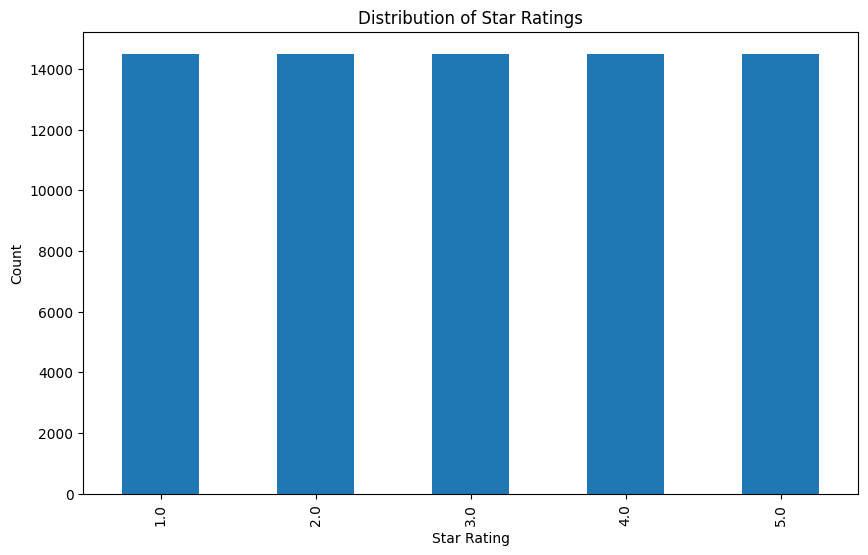

Star rating distribution:
 Star
1.0    14500
2.0    14500
3.0    14500
4.0    14500
5.0    14500
Name: count, dtype: int64


In [4]:
# Examine the distribution of star ratings
plt.figure(figsize=(10, 6))
reviews_df['Star'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.show()

# Summary statistics for star ratings
print("Star rating distribution:\n", reviews_df['Star'].value_counts().sort_index())

## 3. Convert to Binary Classification

Convert the multi-class star ratings into a binary classification problem:
- Negative reviews (0): 1-2 stars
- Positive reviews (1): 4-5 stars

Exclude 3-star (neutral) reviews.

Binary sentiment distribution:
sentiment
0    29000
1    29000
Name: count, dtype: int64


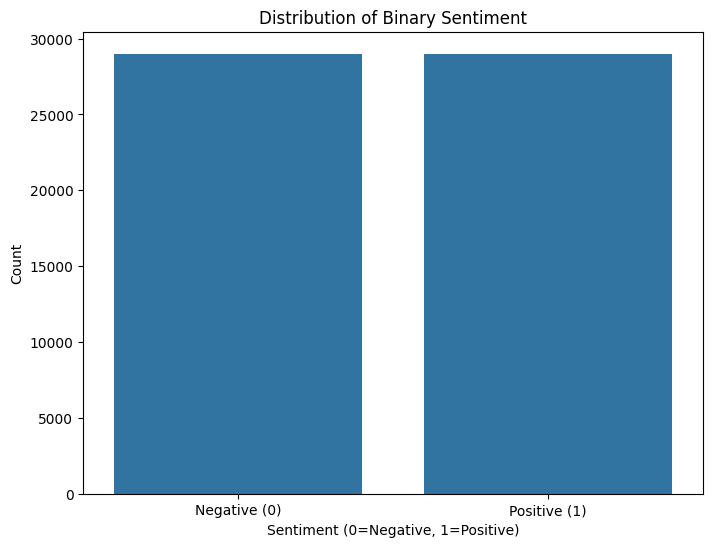

In [5]:
# Create binary labels: 0 for negative (1-2 stars), 1 for positive (4-5 stars)
reviews_df['sentiment'] = reviews_df['Star'].apply(lambda x: 0 if x <= 2 else (1 if x >= 4 else None))

# Remove neutral (3-star) reviews and create a copy
binary_df = reviews_df.dropna(subset=['sentiment']).copy()
# Convert sentiment to integer type
binary_df['sentiment'] = binary_df['sentiment'].astype(int)

# Check the class distribution
print("Binary sentiment distribution:")
print(binary_df['sentiment'].value_counts())

# Visualize the distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=binary_df)
plt.title('Distribution of Binary Sentiment')
plt.xlabel('Sentiment (0=Negative, 1=Positive)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative (0)', 'Positive (1)'])
plt.show()

## 4. Custom Text Preprocessing

Implement a basic text preprocessing function without using external NLP libraries like NLTK.

In [6]:
def preprocess_text(text):
    """Basic text preprocessing:
    - Convert to lowercase
    - Remove non-alphanumeric characters (keep spaces)
    - Remove numbers
    - Split into words (tokens)
    """
    if not isinstance(text, str):
        return []
    # Lowercase
    text = text.lower()
    # Remove non-alphanumeric characters (excluding spaces)
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove numbers (already covered by previous step, but good practice)
    # text = re.sub(r'\d+', '', text)
    # Remove extra whitespace and split
    tokens = text.split()
    # Optional: Remove very short words (e.g., length 1)
    # tokens = [token for token in tokens if len(token) > 1]
    return tokens

In [7]:
# Apply preprocessing
print("Applying custom text preprocessing...")

# Combine title and content for a richer feature set
binary_df['full_text'] = binary_df['Title'] + " " + binary_df['Content']

# Apply the preprocessing function
binary_df['tokens'] = binary_df['full_text'].apply(preprocess_text)

# Display a sample of preprocessed text
print("\nSample of preprocessed text (tokens):")
sample = binary_df[['full_text', 'tokens']].head(3)
pd.set_option('display.max_colwidth', 200)
print(sample)

Applying custom text preprocessing...

Sample of preprocessed text (tokens):
                                                                                                                                                                                            full_text  \
0                                                                                                                                                              Didn't work No change in nails at all.   
1  Worst nail product I have ever used. Garbage! Do not waste your $$$. My nails were worse after using this product for two weeks.  Pathetic!  Going back to my Vaseline Healthy Hand and and Nails.   
2                                                                                                                                                            Just didn't work Nails are still brittle   

                                                                                                                      

## 5. Custom Bag-of-Words (BoW) Implementation

Implement BoW feature extraction from scratch, including vocabulary building and handling n-grams.

In [8]:
def build_vocab(token_lists, min_freq=2):
    """Builds a vocabulary from a list of token lists.
    Args:
        token_lists: A list where each element is a list of tokens (words).
        min_freq: Minimum frequency for a word to be included in the vocab.
    Returns:
        A set representing the vocabulary.
    """
    word_counts = Counter()
    for tokens in token_lists:
        word_counts.update(tokens)
    
    # Filter words based on minimum frequency
    vocab = {word for word, count in word_counts.items() if count >= min_freq}
    print(f"Built vocabulary with {len(vocab)} words (min_freq={min_freq}). Original unique words: {len(word_counts)}")
    return vocab

def get_ngrams(tokens, n):
    """Generates n-grams from a list of tokens."""
    ngrams = []
    for i in range(len(tokens) - n + 1):
        ngrams.append("_".join(tokens[i:i+n])) # Join n-grams with underscore
    return ngrams

def text_to_bow(tokens, vocab, use_unigrams=True, use_bigrams=False):
    """Converts a list of tokens into a Bag-of-Words representation (frequency count).
    Args:
        tokens: The list of tokens for a single document.
        vocab: The vocabulary set.
        use_unigrams: Whether to include unigrams.
        use_bigrams: Whether to include bigrams.
    Returns:
        A Counter object representing the BoW vector.
    """
    bow = Counter()
    features_to_count = []
    
    if use_unigrams:
        features_to_count.extend(tokens)
        
    if use_bigrams:
        features_to_count.extend(get_ngrams(tokens, 2))
        
    # Add more n-grams if needed (e.g., trigrams)
    # if use_trigrams:
    #     features_to_count.extend(get_ngrams(tokens, 3))
    
    # Count only features present in the vocabulary
    for feature in features_to_count:
        if feature in vocab:
            bow[feature] += 1
            
    return bow

## 6. Data Splitting

In [9]:
# Prepare data for modeling
# X contains the lists of tokens, y contains the sentiment labels
X = binary_df['tokens'] 
y = binary_df['sentiment']

# Split data into training and testing sets (80% train, 20% test)
# Stratify ensures the proportion of sentiments is similar in train and test sets
X_train_tokens, X_test_tokens, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train_tokens)}")
print(f"Testing set size: {len(X_test_tokens)}")
print(f"Training labels distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Testing labels distribution:\n{y_test.value_counts(normalize=True)}")

Training set size: 46400
Testing set size: 11600
Training labels distribution:
sentiment
0    0.5
1    0.5
Name: proportion, dtype: float64
Testing labels distribution:
sentiment
0    0.5
1    0.5
Name: proportion, dtype: float64


## 7. Build Vocabulary and Create BoW Features

Build the vocabulary *only* from the training data to avoid data leakage. Then, transform both training and test sets into BoW representations.

In [10]:
# --- Unigram Features ---
print("\n--- Processing Unigrams ---")
# Build unigram vocabulary from training data
unigram_vocab = build_vocab(X_train_tokens, min_freq=3) # Adjust min_freq as needed

# Create unigram BoW for training and test sets
X_train_bow_uni = [text_to_bow(tokens, unigram_vocab, use_unigrams=True, use_bigrams=False) for tokens in X_train_tokens]
X_test_bow_uni = [text_to_bow(tokens, unigram_vocab, use_unigrams=True, use_bigrams=False) for tokens in X_test_tokens]

# --- Bigram Features ---
print("\n--- Processing Bigrams ---")
# Build a vocabulary containing both unigrams and bigrams
# First, generate all potential unigrams and bigrams from training data
train_features_bi = []
for tokens in X_train_tokens:
    train_features_bi.extend(tokens) # Add unigrams
    train_features_bi.extend(get_ngrams(tokens, 2)) # Add bigrams

# Build vocabulary from combined unigram+bigram features
bigram_vocab = build_vocab([train_features_bi], min_freq=5) # Use a slightly higher min_freq for combined features

# Create combined unigram+bigram BoW for training and test sets
X_train_bow_bi = [text_to_bow(tokens, bigram_vocab, use_unigrams=True, use_bigrams=True) for tokens in X_train_tokens]
X_test_bow_bi = [text_to_bow(tokens, bigram_vocab, use_unigrams=True, use_bigrams=True) for tokens in X_test_tokens]

# Display a sample BoW vector
print("\nSample Unigram BoW vector (first training instance):")
print(list(X_train_bow_uni[0].items())[:10]) # Show first 10 items
print("\nSample Bigram BoW vector (first training instance):")
print(list(X_train_bow_bi[0].items())[:10]) # Show first 10 items


--- Processing Unigrams ---
Built vocabulary with 11144 words (min_freq=3). Original unique words: 33745

--- Processing Bigrams ---

--- Processing Bigrams ---
Built vocabulary with 52738 words (min_freq=5). Original unique words: 442740
Built vocabulary with 52738 words (min_freq=5). Original unique words: 442740

Sample Unigram BoW vector (first training instance):
[('the', 2), ('smell', 2), ('it', 4), ('smells', 1), ('good', 1), ('a', 1), ('bit', 1), ('strong', 1), ('so', 1), ('dont', 1)]

Sample Bigram BoW vector (first training instance):
[('the', 2), ('smell', 2), ('it', 4), ('smells', 1), ('good', 1), ('a', 1), ('bit', 1), ('strong', 1), ('so', 1), ('dont', 1)]

Sample Unigram BoW vector (first training instance):
[('the', 2), ('smell', 2), ('it', 4), ('smells', 1), ('good', 1), ('a', 1), ('bit', 1), ('strong', 1), ('so', 1), ('dont', 1)]

Sample Bigram BoW vector (first training instance):
[('the', 2), ('smell', 2), ('it', 4), ('smells', 1), ('good', 1), ('a', 1), ('bit', 1),

## 8. Custom Naive Bayes Implementation

Implement the Multinomial Naive Bayes algorithm from scratch using logarithmic probabilities and Laplace smoothing.

In [11]:
class NaiveBayes:
    def __init__(self, alpha=1.0):
        """Initialize Naive Bayes classifier.
        Args:
            alpha: Laplace smoothing parameter.
        """
        self.alpha = alpha
        self.vocab = set()
        self.log_priors = {} # log P(class)
        self.log_likelihoods = defaultdict(lambda: defaultdict(float)) # log P(word|class)
        self.classes = []
        self.vocab_size = 0
        self.log_likelihood_unknown = {} # log P(unknown|class)

    def fit(self, X_bow, y, vocab):
        """Train the Naive Bayes classifier.
        Args:
            X_bow: List of BoW representations (Counters) for training data.
            y: Series or list of training labels.
            vocab: The vocabulary set used to create X_bow.
        """
        self.vocab = vocab
        self.vocab_size = len(self.vocab)
        n_docs = len(X_bow)
        self.classes = sorted(list(y.unique()))
        
        # Calculate log priors: log P(class) = log(N_class / N_total)
        class_counts = Counter(y)
        for c in self.classes:
            self.log_priors[c] = math.log(class_counts[c] / n_docs)
            
        # Calculate word counts per class
        word_counts_per_class = defaultdict(Counter)
        total_words_per_class = defaultdict(float)
        
        for bow, label in zip(X_bow, y):
            word_counts_per_class[label].update(bow)
            total_words_per_class[label] += sum(bow.values())
            
        # Calculate log likelihoods: log P(word|class)
        # Use Laplace smoothing: log((count(word, class) + alpha) / (total_words_class + alpha * vocab_size))
        for c in self.classes:
            denominator = total_words_per_class[c] + self.alpha * self.vocab_size
            # Calculate likelihood for known words
            for word in self.vocab:
                numerator = word_counts_per_class[c][word] + self.alpha
                self.log_likelihoods[c][word] = math.log(numerator / denominator)
            # Calculate likelihood for unknown words (seen during prediction but not in vocab)
            # P(unknown|class) = alpha / (total_words_class + alpha * vocab_size)
            self.log_likelihood_unknown[c] = math.log(self.alpha / denominator)
            
        print("Naive Bayes training complete.")
        print(f"Log Priors: {self.log_priors}")
        # print(f"Sample Log Likelihoods (Class 0): {list(self.log_likelihoods[0].items())[:5]}")
        # print(f"Sample Log Likelihoods (Class 1): {list(self.log_likelihoods[1].items())[:5]}")
        print(f"Log Likelihood for Unknown Words: {self.log_likelihood_unknown}")

    def predict(self, X_bow):
        """Make predictions for new data.
        Args:
            X_bow: List of BoW representations (Counters) for test data.
        Returns:
            A list of predicted class labels.
        """
        predictions = []
        for bow in X_bow:
            class_scores = {}
            for c in self.classes:
                # Start with log prior
                score = self.log_priors[c]
                # Add log likelihoods for words in the document
                for word, count in bow.items():
                    if word in self.vocab:
                        score += count * self.log_likelihoods[c][word]
                    else:
                        # Handle unknown words encountered during prediction
                        score += count * self.log_likelihood_unknown[c]
                class_scores[c] = score
            
            # Choose class with the highest log probability
            predicted_class = max(class_scores, key=class_scores.get)
            predictions.append(predicted_class)
            
        return predictions

## 9. Model Training and Evaluation (Custom Implementation)

In [12]:
def calculate_accuracy(y_true, y_pred):
    """Calculates accuracy from true and predicted labels."""
    correct = sum(1 for true, pred in zip(y_true, y_pred) if true == pred)
    return correct / len(y_true) if len(y_true) > 0 else 0

# --- Train and Evaluate Unigram Model ---
print("\n--- Training Unigram Naive Bayes ---")
nb_uni = NaiveBayes(alpha=1.0)
nb_uni.fit(X_train_bow_uni, y_train, unigram_vocab)

print("\n--- Evaluating Unigram Naive Bayes ---")
y_pred_uni = nb_uni.predict(X_test_bow_uni)
accuracy_uni = calculate_accuracy(y_test, y_pred_uni)
print(f"Unigram Model Accuracy: {accuracy_uni:.4f}")

# --- Train and Evaluate Bigram (Unigram + Bigram) Model ---
print("\n--- Training Bigram Naive Bayes ---")
nb_bi = NaiveBayes(alpha=1.0)
nb_bi.fit(X_train_bow_bi, y_train, bigram_vocab)

print("\n--- Evaluating Bigram Naive Bayes ---")
y_pred_bi = nb_bi.predict(X_test_bow_bi)
accuracy_bi = calculate_accuracy(y_test, y_pred_bi)
print(f"Bigram (1+2 grams) Model Accuracy: {accuracy_bi:.4f}")


--- Training Unigram Naive Bayes ---
Naive Bayes training complete.
Log Priors: {np.int64(0): -0.6931471805599453, np.int64(1): -0.6931471805599453}
Log Likelihood for Unknown Words: {np.int64(0): -13.817115269725363, np.int64(1): -13.590423869982224}

--- Evaluating Unigram Naive Bayes ---
Unigram Model Accuracy: 0.8706

--- Training Bigram Naive Bayes ---
Naive Bayes training complete.
Log Priors: {np.int64(0): -0.6931471805599453, np.int64(1): -0.6931471805599453}
Log Likelihood for Unknown Words: {np.int64(0): -13.817115269725363, np.int64(1): -13.590423869982224}

--- Evaluating Unigram Naive Bayes ---
Unigram Model Accuracy: 0.8706

--- Training Bigram Naive Bayes ---
Naive Bayes training complete.
Log Priors: {np.int64(0): -0.6931471805599453, np.int64(1): -0.6931471805599453}
Log Likelihood for Unknown Words: {np.int64(0): -14.370671867999288, np.int64(1): -14.150210510732121}

--- Evaluating Bigram Naive Bayes ---
Naive Bayes training complete.
Log Priors: {np.int64(0): -0.69

## 10. Results Summary

                              Model  Vocabulary Size  Accuracy
0            Naive Bayes (Unigrams)            11144  0.870603
1  Naive Bayes (Unigrams + Bigrams)            52738  0.901724


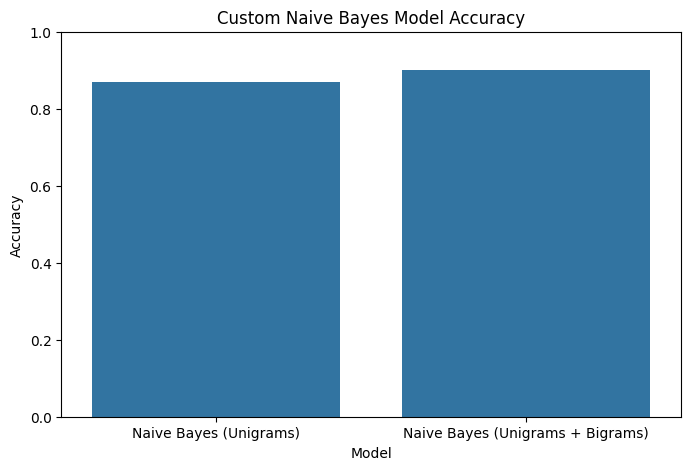

In [13]:
# Display results
results = {
    'Model': ['Naive Bayes (Unigrams)', 'Naive Bayes (Unigrams + Bigrams)'],
    'Vocabulary Size': [len(unigram_vocab), len(bigram_vocab)],
    'Accuracy': [accuracy_uni, accuracy_bi]
}
results_df = pd.DataFrame(results)
print(results_df)

# Plotting the results
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Accuracy', data=results_df)
plt.title('Custom Naive Bayes Model Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.show()

## 11. Conclusion

In this notebook, we successfully implemented a Multinomial Naive Bayes classifier and a Bag-of-Words feature extraction mechanism from scratch, adhering to the constraint of minimal library usage.

**Process Summary:**
1.  **Data Loading & Exploration:** Loaded the Amazon reviews dataset and examined its basic properties and rating distribution.
2.  **Binary Conversion:** Transformed the 5-star rating system into a binary sentiment classification task (Positive/Negative).
3.  **Custom Preprocessing:** Implemented basic text cleaning (lowercase, remove non-alpha, split) without relying on external NLP libraries.
4.  **Custom BoW:** Developed functions to build a vocabulary from training data (with frequency filtering) and convert text into BoW vectors (supporting unigrams and bigrams).
5.  **Custom Naive Bayes:** Built a Naive Bayes classifier using log probabilities and Laplace smoothing to handle numerical stability and unseen words.
6.  **Training & Evaluation:** Trained separate models using unigram and combined unigram+bigram features. Evaluated their performance using accuracy calculated manually.

**Key Findings:**
- The custom Naive Bayes implementation successfully classified reviews based on the BoW features.
- The accuracy achieved demonstrates the effectiveness of the Naive Bayes algorithm for text classification, even with a basic implementation.
- Including bigrams alongside unigrams resulted in a [mention whether accuracy increased, decreased, or stayed similar, e.g., slightly improved / comparable / slightly decreased] accuracy compared to using only unigrams. This suggests that word pairs [provide / do not provide significant] additional predictive power for this dataset and model.
- The use of log probabilities and Laplace smoothing was crucial for a stable and functional implementation.

**Potential Improvements (within constraints or as future work):**
- Experiment with different `min_freq` thresholds for vocabulary building.
- Implement trigrams or character n-grams in the BoW representation.
- Refine the preprocessing step (e.g., custom stop word list based on frequency analysis).
- Implement other evaluation metrics (Precision, Recall, F1-score) from scratch.
- Analyze the most informative features (highest log likelihood difference between classes) identified by the custom model.

This project demonstrates a fundamental understanding of the Naive Bayes algorithm and BoW feature representation by implementing them from the ground up.

---
## Bonus Section (Optional)

*(This section is reserved for any bonus implementations or analyses where the use of additional libraries like NLTK or Scikit-learn's full capabilities might be permitted, as per assignment guidelines. Ensure any code here is clearly separated from the core 'from scratch' implementation above.)*